In [1]:
import numpy as np
from collections import Counter

import matplotlib.cm  as cm
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_predict


import sys, os
sys.path.append('..')
from utils import data_preprocesados, etiquetas, plot_labels, plot_some_LP

 instala AntroPy [https://raphaelvallat.com/antropy] pip3 install antropy


In [2]:
X_all = data_preprocesados()

Del cuaderno anterior aprendimos que podemos identificar entre 4 y 5 grandes clusters para clasificar las señales.
En este cuaderno vamos a combinar los algortimos TSNE y GMM para visualizar y seleccionar aquellas señales que pertenezcan (con una alta probabilidad) a una clase definida. De esta forma vamos a poder comparar señales y clasificar manualmente para tener algunas etiquetas.

## 1. TSNE + GMM

In [3]:
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(X_all)

C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [4]:
n = 7
gmm = GaussianMixture(n_components=n, n_init=10, random_state=45).fit(X_valid_2D)
y_predict = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)

labels = list(Counter(y_predict).keys())

print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_valid_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_valid_2D):.0f}')
print('\n', Counter(y_predict))

 Akaike information criterion (AIC):  17284
 Bayesian information criterion (BIC):  17487

 Counter({0: 294, 2: 151, 3: 143, 1: 141, 6: 140, 4: 114, 5: 61})


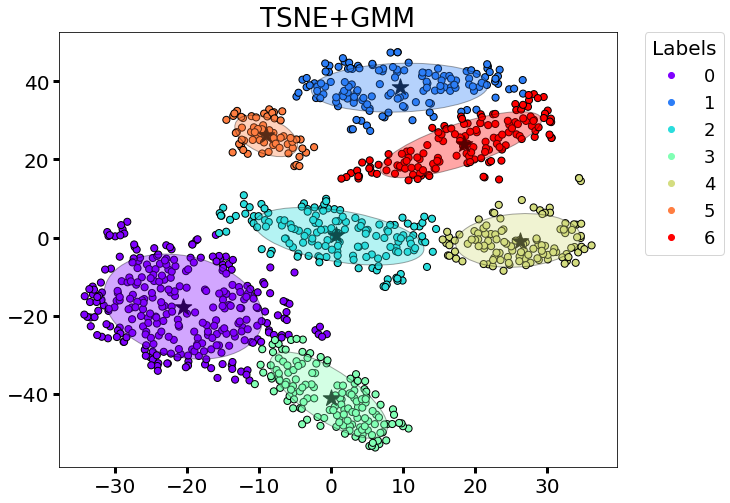

In [5]:
plot_labels(X_valid_2D, y_predict, cmap='rainbow', title='TSNE+GMM', show_centroid=True ,ellipse=(gmm.means_, gmm.covariances_))
plt.savefig('TSNE-GMM.png', bbox_inches = 'tight')
plt.show()
plt.close()

In [6]:
y, y_best = np.where(prob>0.996)
y_best_label = list(Counter(y_best).keys())
y_best_label.sort()

print(f'Total: {len(y)}') 
print('Label, nro_LPs')
print('---------------')
for n in y_best_label:
    i = Counter(y_best)[n]
    print(f'{n:^5}', f'{i:^7}')

Total: 514
Label, nro_LPs
---------------
  0     164  
  1     111  
  2     22   
  3     71   
  4     46   
  5     27   
  6     73   


5 [113 303 250]


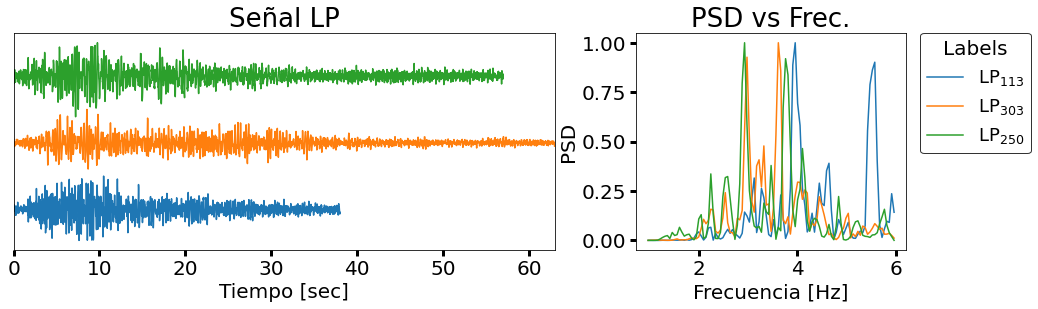

In [12]:
plot_some_LP(y_best, 5, rand_int=3, y_index=y)
plt.savefig('TSNE-GMM_LP1.png', bbox_inches = 'tight')
plt.show()
plt.close()

Hemos tenido que reducir el tamaño en el GMM para ir buscando una clasificación balanceada.
Con un 99.6% de probabilidad de pertenencia de clase, 569 señales (~50%) pueden ser clasificadas en etiquetas bien balanceadas.

## 2.Etiquetado manual

Por otro lado, una comparación visual entre estos pares de señales nos ha permitido emparejar 97 señales de LP en 15 etiquetas.

In [13]:
y_valid, y_valid_labels = etiquetas()
print('Supervised labels: ', len(y_valid))
print('Sup_label, nro_LPs')
print('------------------')
y_valid_label = list(Counter(y_valid_labels).keys())
y_valid_label.sort()
for n in y_valid_label:
    i = Counter(y_valid_labels)[n]
    print(f'{n:^9}', f'{i:^7}')

Supervised labels:  97
Sup_label, nro_LPs
------------------
    1       28   
    2       10   
    3        4   
    4       30   
    5        3   
    6        3   
    7        2   
    8        3   
    9        2   
   10        2   
   11        2   
   12        2   
   13        2   
   14        2   
   15        2   


2 [168 180 258]


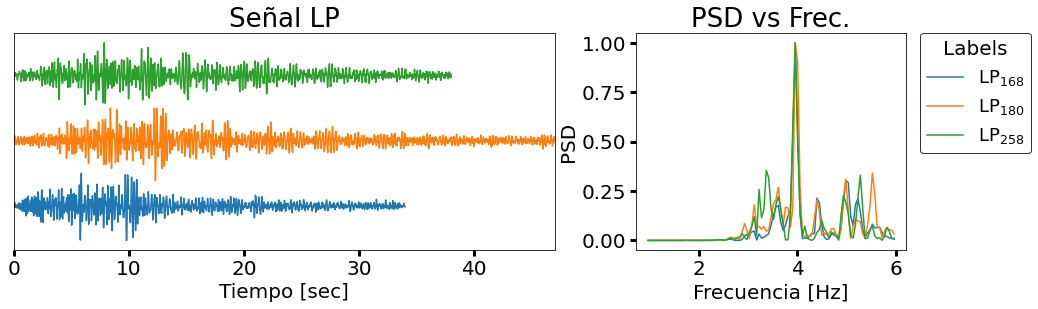

In [15]:
plot_some_LP(y_valid_labels, 2, rand_int=3, y_index=y_valid)
plt.savefig('TSNE-GMM_manual_LP2.png', bbox_inches = 'tight')
plt.show()
plt.close()

Establecer estas etiquetas no fue sencillo, primero tuvimos que ir comparando entre pares de señales. Cuando estás se daban, se iban guardando. Luego diseñar codigos sencillos que juntaran indices repetidos con el fin de hacer cadenas largas de índices de señales de una misma clase.

Esto último contribuye a la propagación de errores sistémicos. La complejidad de las comparación es tal que cuando se visualiza el resultado es posible que señales con una misma etiqueta no resulten tan parecidos como uno esperaría.

In [10]:
valid_label = 1
k_sup_index = y_valid[np.where(y_valid_labels==valid_label)] # resultados supervisados
k_sup_index_rand = k_sup_index[np.random.choice(k_sup_index.shape[0], 10, replace=False)]

print('supervised_label: ', valid_label)
print('LP_index,  GMM_label')
print('-------------------')

for kid in k_sup_index_rand:
    print(f'{kid:^8}', '   ', y_predict[kid])


supervised_label:  1
LP_index,  GMM_label
-------------------
  206        0
  315        2
  340        2
  162        2
  116        2
  778        1
  959        2
  115        2
  112        2
  156        2


Esto significa que no hay compatibilidad entre nuestros resultados y los resultados del TSNE+GMM.
La idea de mostarar estos resultados es evidenciar la dificultad del problema.

In [11]:
print('Sup_label   gmm_label:n_Lps')
print('---------------------------')

for i in y_valid_label:
    k_sup_index = y_valid[np.where(y_valid_labels==i)]
    gmm_labels = Counter([y_predict[kid] for kid in k_sup_index])
    print(f'{i:^9}', dict(gmm_labels))

Sup_label   gmm_label:n_Lps
---------------------------
    1     {0: 4, 2: 16, 5: 1, 4: 5, 1: 2}
    2     {0: 1, 2: 8, 4: 1}
    3     {3: 1, 4: 2, 2: 1}
    4     {0: 11, 2: 17, 1: 1, 4: 1}
    5     {2: 1, 4: 1, 1: 1}
    6     {2: 2, 1: 1}
    7     {2: 1, 0: 1}
    8     {4: 1, 5: 2}
    9     {4: 1, 2: 1}
   10     {2: 2}
   11     {2: 2}
   12     {2: 1, 4: 1}
   13     {2: 1, 4: 1}
   14     {4: 2}
   15     {4: 2}


Estos resultados son incongruentes.

Pero como no podemos entrenar un clasificador sin etiquetas, y dado que nuestro esfuerzo por etiquetar manualmente las señales por inspección visual tampoco arroja resultados correctos, consideraremos las etiquetas arrojadas por el modelo TSNE+GMM como correctas.

## 3. LogisticRegresion / Propagacion de etiquetas

Vamos a considerar como ciertas las y_best (prob > 99.6%) para entrenar un clasificador. 

In [12]:
X_labeled = np.empty((y.shape[0], X_all.shape[1]))
X_forlabel = np.empty((X_all.shape[0]-y.shape[0], X_all.shape[1]))
X_forlabel_index = []
y_forlabel = []

nl = 0
nf = 0
for n in range(X_all.shape[0]):
    if n in y:
        X_labeled[nl,:] = X_all[n,:]
        nl += 1
    else:
        X_forlabel[nf,:] = X_all[n,:]
        y_forlabel.append(np.argmax(prob[n]))
        X_forlabel_index.append(n)
        nf += 1

In [13]:
print('Total: ', X_labeled.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_best, test_size=0.25, random_state=15)
print('Entrenamiento: ', X_train.shape) 
print('Validación: ',X_test.shape)

Total:  (493, 16) (493,)
Entrenamiento:  (369, 16)
Validación:  (124, 16)


Recall:  0.99
Precision:  0.99
[[ 16   0   1   0   0   0   0]
 [  0  84   0   0   0   0   0]
 [  0   0 116   0   0   0   0]
 [  0   0   0  56   0   0   0]
 [  0   0   0   0  55   0   0]
 [  0   2   0   0   0  17   0]
 [  0   0   0   0   0   0  22]]


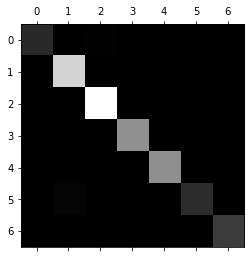

In [14]:
lr = LogisticRegression(penalty='l2', fit_intercept=False, C=1.0)
lr.fit(X_train, y_train)
y_train_pred_CG = cross_val_predict(lr, X_train, y_train, cv=5)
conf_cm = confusion_matrix(y_train, y_train_pred_CG)
plt.matshow(conf_cm, cmap='Greys_r')
print("Recall: ", f"{recall_score(y_train, y_train_pred_CG, average='weighted'):.2f}")
print("Precision: ", f"{precision_score(y_train, y_train_pred_CG, average='weighted'):.2f}")
print(conf_cm)
plt.savefig('Logistic_conf-matrix_test.png', bbox_inches = 'tight')
plt.show()
plt.close()

El modelo es muy preciso y practicamente no se equivoca, pero ¿generalizara bien?

[[ 4  0  0  0  0  0  0]
 [ 0 26  0  1  0  0  0]
 [ 0  0 34  0  1  0  0]
 [ 0  0  0 20  0  0  0]
 [ 0  0  0  0 21  0  0]
 [ 0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  8]]
Recall:  0.98
Precision:  0.98


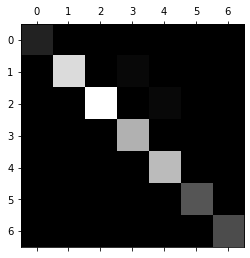

In [15]:
conf_cm_test = confusion_matrix(y_test, lr.predict(X_test))
print(conf_cm_test)
plt.matshow(conf_cm_test, cmap='Greys_r')
print("Recall: ", f"{recall_score(y_test, lr.predict(X_test), average='weighted'):.2f}")
print("Precision: ", f"{precision_score(y_test, lr.predict(X_test), average='weighted'):.2f}")
plt.savefig('Logistic_conf-matrix_valid.png', bbox_inches = 'tight')
plt.show()
plt.close()

Pues parece que generaliza muy bien. 

## 4. Comparación de modelos

Comparar el TSNE+GMM con el Logistico

[[110   0  18   0   2   1   5]
 [  0  23   0   6   0   0   0]
 [ 10   0 122   1   1   0   1]
 [  0   0   0  65   0   0   0]
 [  0   0  26   0  49   0   0]
 [ 20   0   0   0   7  53   0]
 [  0   2   0   0   0   4  25]]
Recall:  0.81
Precision:  0.82


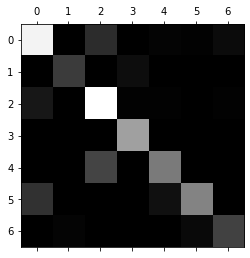

In [16]:
y_result = lr.predict(X_forlabel)
conf_cm_gmm = confusion_matrix(y_forlabel, y_result)
print(conf_cm_gmm)
print("Recall: ", f"{recall_score(y_forlabel, y_result, average='weighted'):.2f}")
print("Precision: ", f"{precision_score(y_forlabel, y_result, average='weighted'):.2f}")
plt.matshow(conf_cm_gmm, cmap='Greys_r')
plt.savefig('GMM_conf-matrix_valid.png', bbox_inches = 'tight')
plt.show()
plt.close()

Hay una etiqueta que falla que tiene que ver con la poca de densidad de datos. 
Por otro lado, vemos que el clasificador podría andar bien

C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


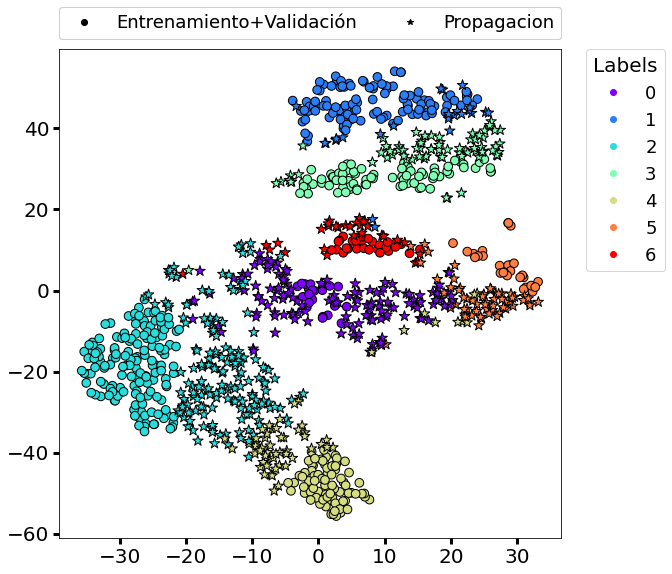

In [17]:
X_joint = np.concatenate((X_forlabel, X_labeled))
Y_joint = np.concatenate((y_result, y_best))
labels = np.arange(Y_joint.max()+1)

tsne_joint = TSNE(init='pca')
X_joint_2D = tsne_joint.fit_transform(X_joint)

X_forlabel_2D = X_joint_2D[:X_forlabel.shape[0],:]
X_labeled_2D = X_joint_2D[X_forlabel.shape[0]:,:]

fig, ax = plt.subplots(1,1, figsize=(9,9))
cmap = 'rainbow'
norm = mcolors.Normalize(Y_joint.min(), Y_joint.max())
ax.scatter(X_labeled_2D[:,0], X_labeled_2D[:,1], marker='o', ec='k', c=y_best, cmap=cmap, norm=norm, s=75)
ax.scatter(X_forlabel_2D[:,0], X_forlabel_2D[:,1], marker='*', ec='k', c=y_result, cmap=cmap, norm=norm, s=120)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap(cmap)(norm(c)), label=c, alpha=1) for c in labels]
h2 = [plt.Line2D([0], [0], linestyle="none", marker="o", c='k', alpha=1)]
h2 += [plt.Line2D([0], [0], linestyle="none", marker="*", c='k', alpha=1)]


l1 = plt.legend(h, labels, title='Labels', title_fontsize=20, fontsize=18,
                bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.add_artist(l1)
l2 = plt.legend(h2, ['Entrenamiento+Validación', 'Propagacion'], fontsize=18,
                bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
ax.add_artist(l2)
ax.tick_params(axis='both', which='major', labelsize=20, length=6, width=3)
plt.savefig('GMM_propagacion.png', bbox_inches = 'tight')
plt.show()
plt.close()

No hay mucha diferencia entre el resultado obtenido entre TSNE+GMM y el clasificador

In [18]:
y_not = list(set(range(1044)) - set(y)) # índices de LP que no fueron usados para entrenar el Logistico
y_lr = y_result
y_gmm = y_predict[y_not]
print(y_lr.shape, y_gmm.shape)
y_diff = np.array(y_not)[np.where((y_lr-y_gmm) != 0)]
len(y_diff)

(551,) (551,)


104

Por tanto, el Logistico y el TSNE+GMM discrepan en 129 señales, esto es 27%. Vamos a sacarlas del gráfico para ver como resulta este

C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


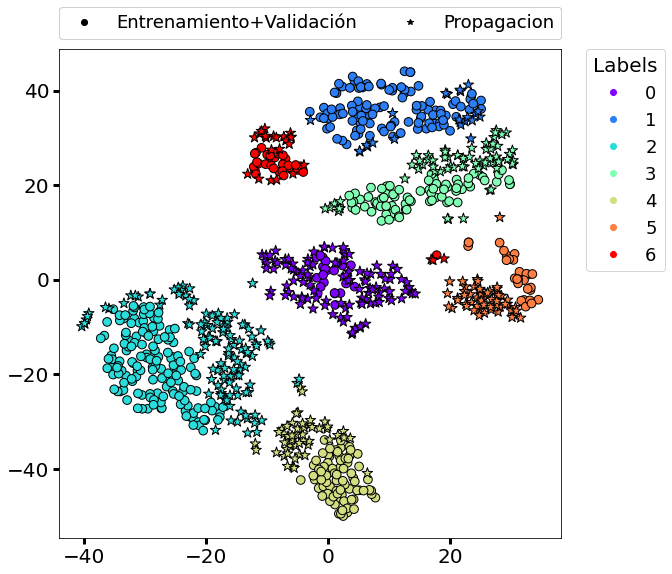

In [19]:
X_forlabel_clean = X_forlabel[np.where((y_lr-y_gmm) == 0)]
y_result_clean = y_result[np.where((y_lr-y_gmm) == 0)]

X_joint = np.concatenate((X_forlabel_clean, X_labeled))
Y_joint = np.concatenate((y_result_clean, y_best))
labels = np.arange(Y_joint.max()+1)

tsne_joint = TSNE(init='pca')
X_joint_2D = tsne_joint.fit_transform(X_joint)

X_forlabel_2D = X_joint_2D[:X_forlabel_clean.shape[0],:]
X_labeled_2D = X_joint_2D[X_forlabel_clean.shape[0]:,:]

fig, ax = plt.subplots(1,1, figsize=(9,9))
cmap = 'rainbow'
norm = mcolors.Normalize(Y_joint.min(), Y_joint.max())
ax.scatter(X_labeled_2D[:,0], X_labeled_2D[:,1], marker='o', ec='k', c=y_best, cmap=cmap, norm=norm, s=75)
ax.scatter(X_forlabel_2D[:,0], X_forlabel_2D[:,1], marker='*', ec='k', c=y_result_clean, cmap=cmap, norm=norm, s=120)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap(cmap)(norm(c)), alpha=1) for c in labels]
h2 = [plt.Line2D([0], [0], linestyle="none", marker="o", c='k', alpha=1)]
h2 += [plt.Line2D([0], [0], linestyle="none", marker="*", c='k', alpha=1)]

l1 = plt.legend(h, labels, title='Labels', title_fontsize=20, fontsize=18,
                bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.add_artist(l1)
l2 = plt.legend(h2, ['Entrenamiento+Validación', 'Propagacion'], fontsize=18,
                bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
ax.add_artist(l2)
ax.tick_params(axis='both', which='major', labelsize=20, length=6, width=3)
plt.savefig('GMM_propagacion_descarte.png', bbox_inches = 'tight')
plt.show()
plt.close()

## Conclusión

La combinación TSNE+GMM ha resultado ser un buen método para clasificar de forma casi no-supervisada las señales.
De hecho, la selección de señales con una buena probabilidad de pertenencia a las clases ha permitido entrenar un regresor logistico capaz de aprender los parametros originales de cada señal y propagar las etiquetas. Hemos visto que un 27% de las etiquetas propagadas no son consistentes con el modelo TSNE+GMM. Por tanto, decidimos quitar estas señales para obtener una figura que si consideramos clasica las señales.
